In [1]:
%%capture
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
from neuronunit.optimisation import make_sim_tests
import numpy as np
from IPython.display import display, HTML
from neuronunit.plottools import plot_score_history1
from neuronunit.optimisation.optimization_management import check_binary_match
from neuronunit.optimisation.optimization_management import inject_and_plot_model

import pandas as pd


# Simulated Data 
and select model parameters that are free to vary


In [2]:
%%capture
model_type="HH"
fps = ['g_L','g_Na','g_K','vr'] 
import make_sim_tests
sim_tests, OM, target = make_sim_tests.test_all_objective_test(fps,model_type=model_type)


# Meta Parameters

In [3]:
MU = 10 
NGEN = 45


In [4]:
results = sim_tests.optimize(backend=model_type,\
        protocol={'allen': False, 'elephant': True},\
            MU=MU,NGEN=NGEN,plot=True,free_parameters=fps)


GA Generation Progress: 100%|██████████| 44/44 [33:13<00:00, 45.32s/it]


In [5]:
opt = results['pf'][0].dtc
OM.tests = opt.tests
opt = OM.format_test(opt)
opt.self_evaluate()
opt = OM.get_agreement(opt)
display(opt.agreement)

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,112.5 pA,105.49653924586214 ms,-65.42296941022838 mV,2619177693.1629815 kg*m**2/(s**3*A**2),4.0278496385047476e-11 s**4*A**2/(kg*m**2),0.0031958333333333335 s,108.81269181078798 mV,-64.02717368779312 mV,NaN
predictions,112.5 pA,105.49187326454407 ms,-64.602574704124 mV,2764467997.224676 kg*m**2/(s**3*A**2),3.8159918425697166e-11 s**4*A**2/(kg*m**2),0.0033583333333333334 s,108.70719745124103 mV,-63.20621446409504 mV,NaN
scores,0,1.76449e-05,0.105297,2.79237,0.0212045,0.0204915,0.000386851,0.00512835,14.74593


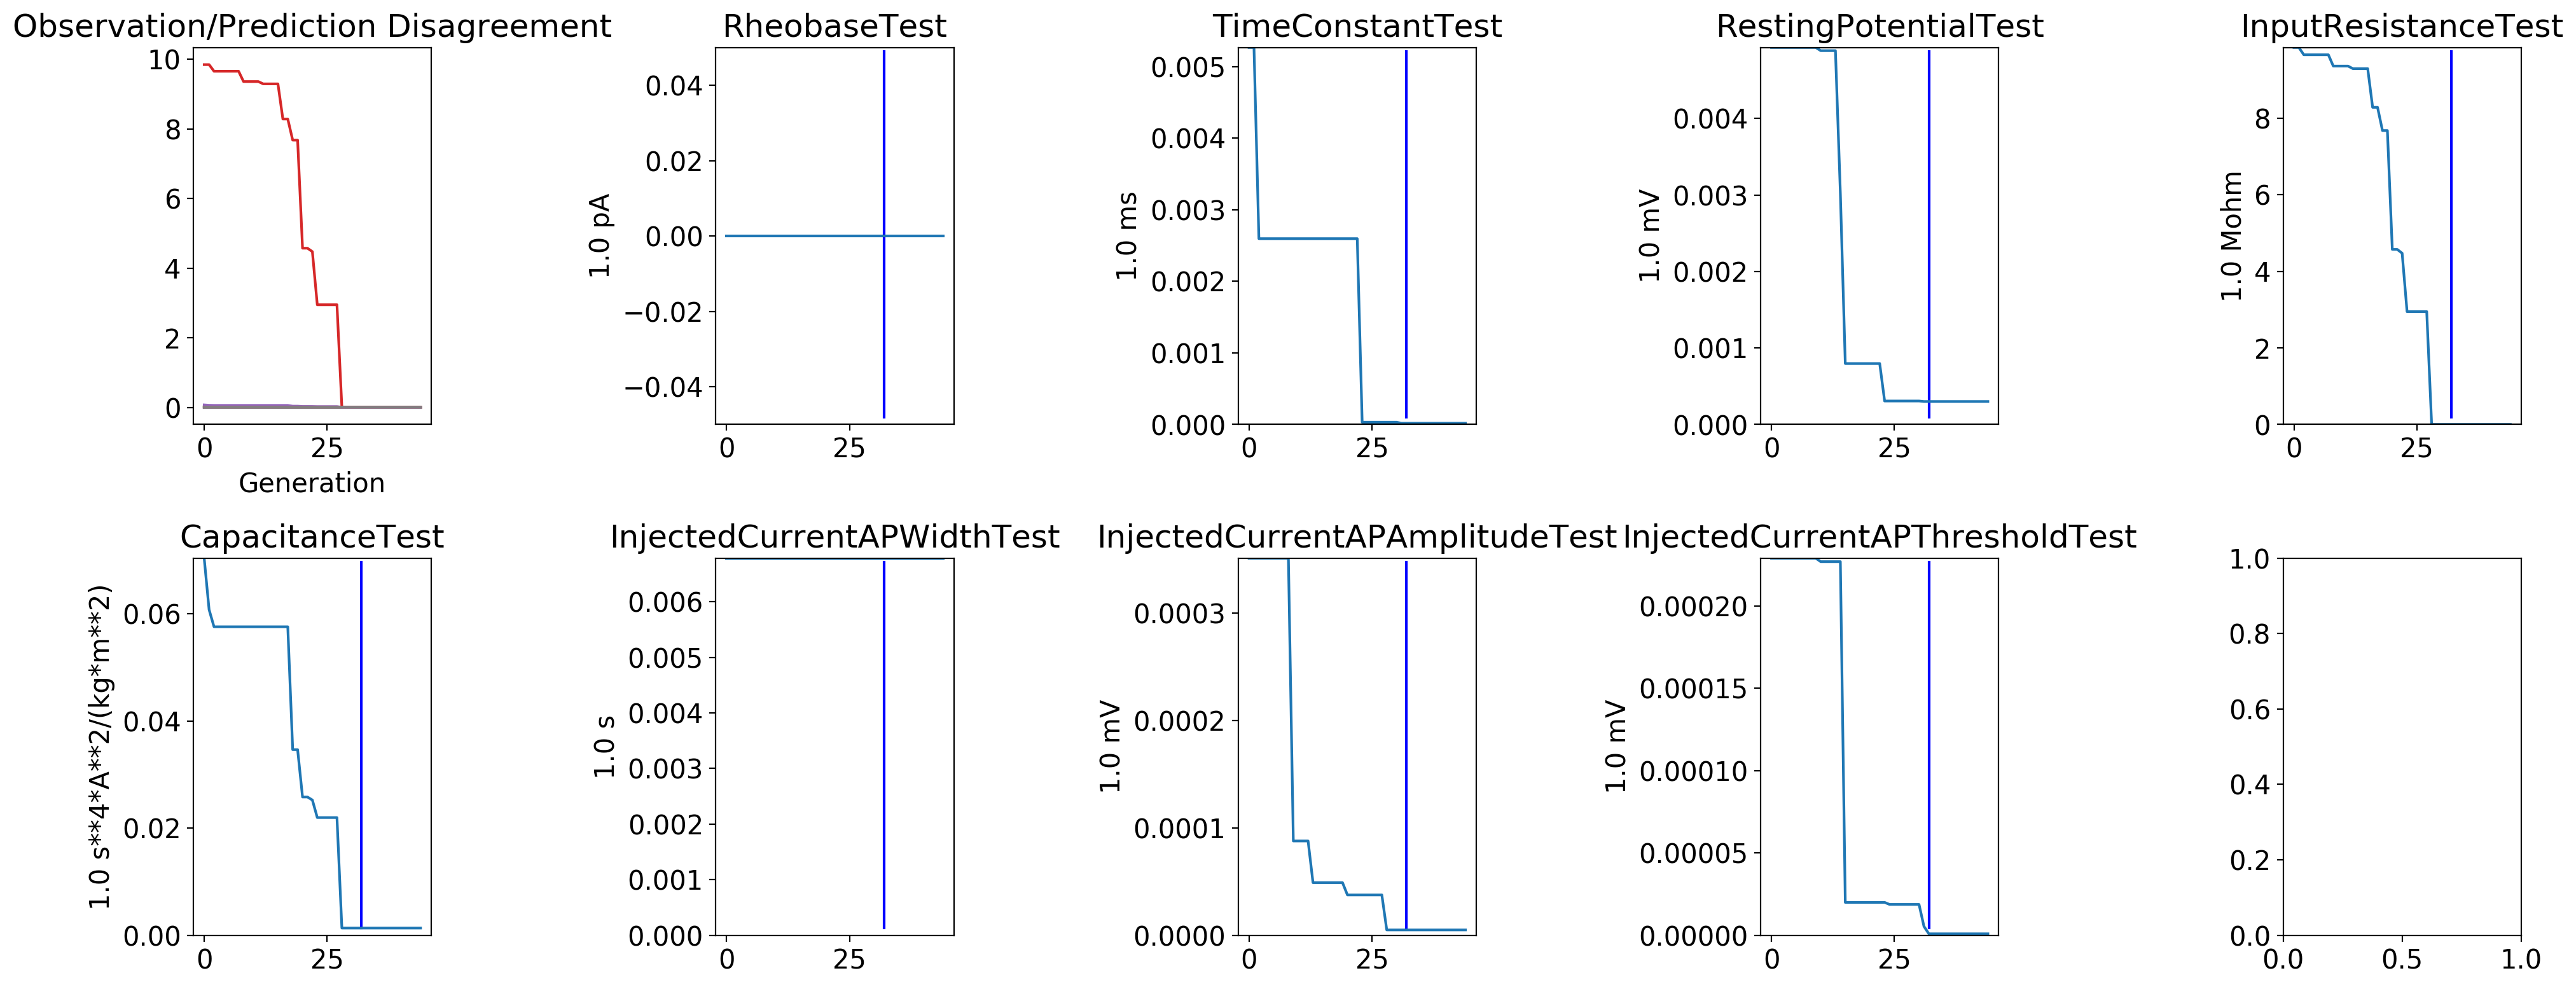

In [6]:

plt = plot_score_history1(results)
plt.show()


<Figure size 640x480 with 0 Axes>

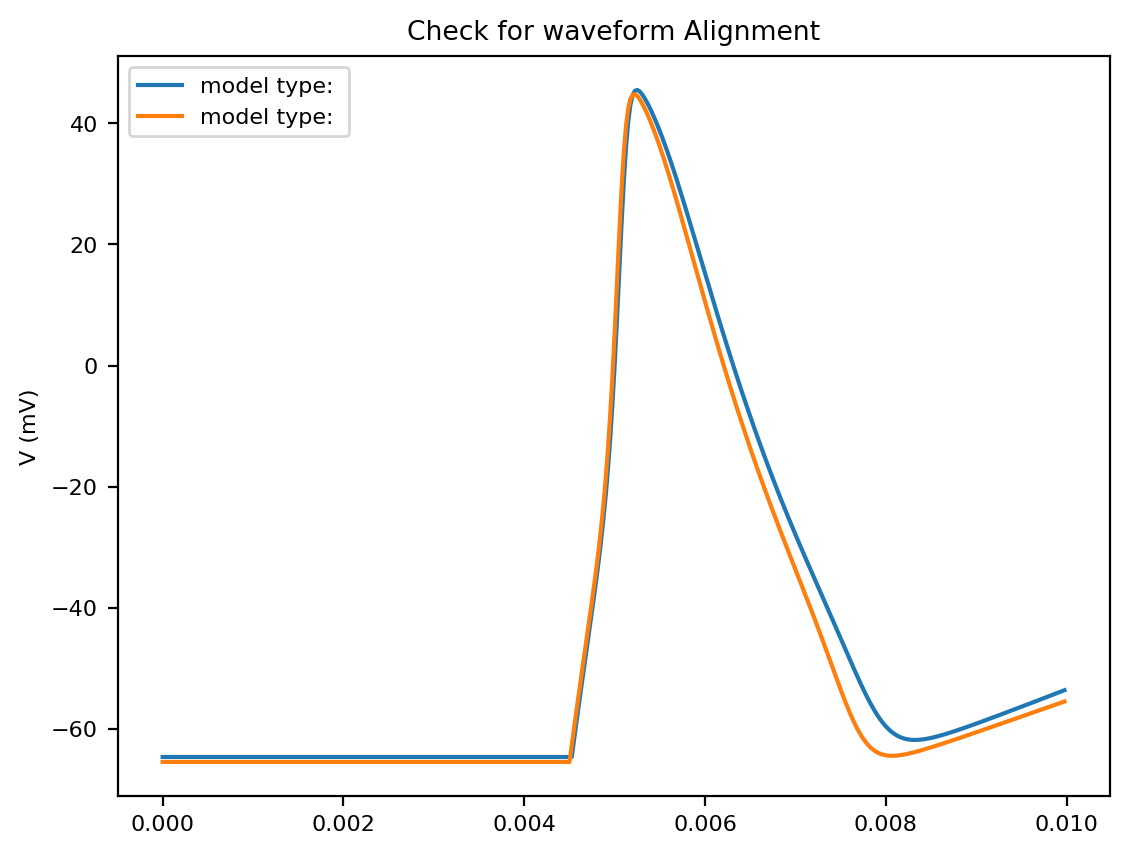

In [7]:
model = target.dtc_to_model()

check_binary_match(opt,target,snippets=True)

target = OM.format_test(target)
simulated_data_tests = target.tests
#


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

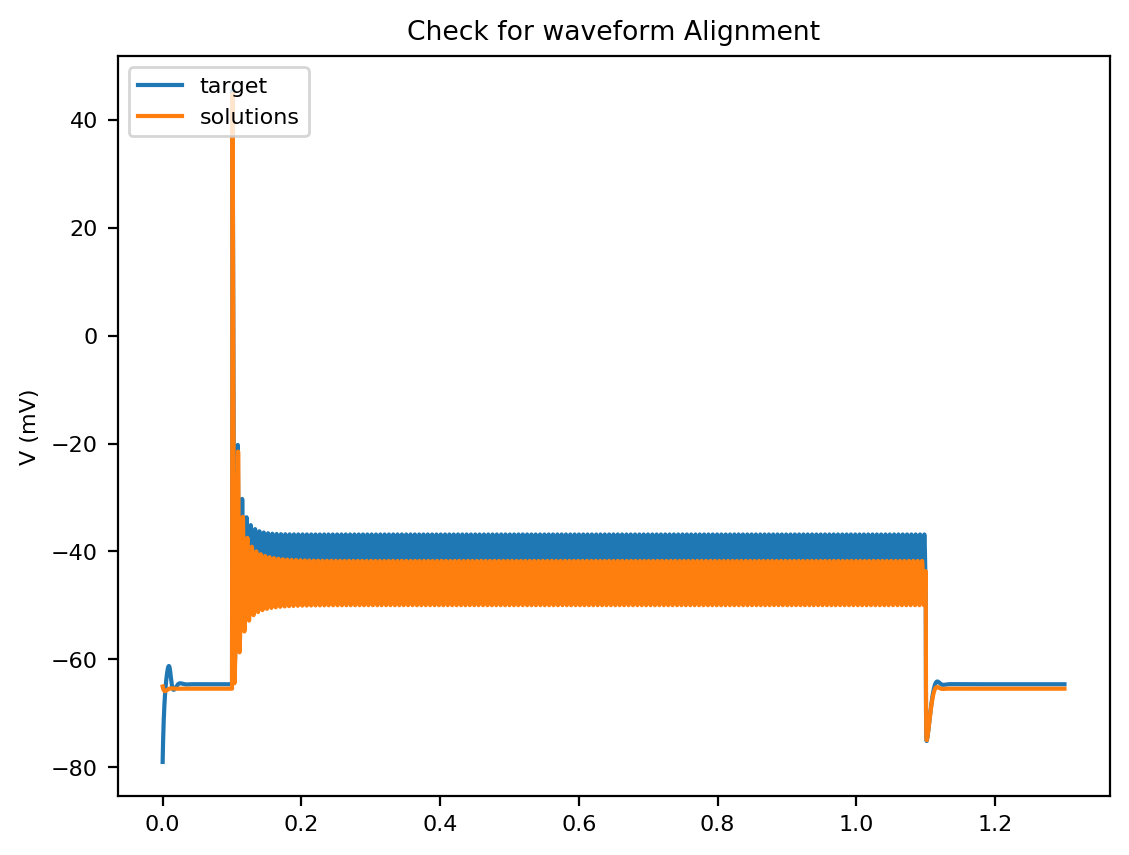

In [8]:
check_binary_match(opt,target,snippets=False)


In [9]:
try:
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)
except:
    pass


In [10]:
display(pd.DataFrame([opt.attrs]))
import copy
temp = {}
for k in opt.attrs.keys():
    temp[k] = target.attrs[k]
display(pd.DataFrame([temp]))

,g_K,g_L,g_Na,vr
0,27.582864,0.264102,93.142521,-78.998727


,g_K,g_L,g_Na,vr
0,35.293818,0.26851,96.639119,-65.019498


What where the values of model parameters that where held constant?


In [11]:
df0 = opt.dtc_to_model().default_attrs
df1 = target.dtc_to_model().default_attrs
hc = {}
for k,v in df0.items():
    if k not in opt.attrs.keys():
        assert df0[k] == df1[k]
        hc[k] = v        
display(pd.DataFrame([hc]))     

,C_m,E_L,E_K,E_Na
0,1.0,-54.387,-77.0,50.0
